# Aprendizaje Automatico - Segunda Entrega Proyecto
## Estudiante: Carlos Hidalgo Escobar

### Pre-procesing data & Training Models: Linear Regression, Random Forest & Gradient Boosting Regressor.
### Dataset: Medical Cost Personal Dataset
### Link: https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download

## Variables
*El dataset cuenta con las siguientes variables*

Variables:
* age: Edad del beneficiario.
* sex: Sexo (male/female).
* bmi: √çndice de masa corporal.
* children: N√∫mero de hijos a cargo.
* smoker: ¬øEs fumador? (yes/no).
* region: Regi√≥n de residencia.
* charges: Costo del seguro m√©dico.

*El cual su variable predictoria es charges (costo del seguro).*

# Importaci√≥n librerias

# Importaci√≥n de Librer√≠as Esenciales

Se importaron librer√≠as esenciales para todo el flujo de trabajo en **machine learning**.

* **pandas** y **numpy** se utilizan para manipular datos tabulares y realizar operaciones matem√°ticas vectorizadas.
* **matplotlib.pyplot** y **seaborn** permiten crear visualizaciones descriptivas y comparativas para entender mejor el comportamiento de las variables y los modelos.
* Desde **sklearn**, se importaron m√≥dulos especializados para:
    * **Preprocesamiento** de datos.
    * Construcci√≥n de **pipelines**.
    * **Entrenamiento de modelos**.
    * **Selecci√≥n de hiperpar√°metros**.
    * **Evaluaci√≥n de rendimiento**.
    * **Diagn√≥stico del modelo**.

Esto proporciona un entorno robusto y coherente para trabajar todo el proyecto desde una sola interfaz.

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error


# Carga dataset y breve EDA.

---
Se ha cargado el dataset `insurance.csv`, el cual contiene informaci√≥n detallada sobre individuos y sus gastos en seguros m√©dicos.

Este dataset es particularmente adecuado para problemas de **regresi√≥n**, dado que la variable objetivo, `charges`, es una **variable num√©rica continua**. Su valor est√° influenciado por diversos factores demogr√°ficos, de estilo de vida y regionales presentes en el dataset, lo que permite predecir los gastos m√©dicos bas√°ndose en estas caracter√≠sticas.

In [206]:
# 2. Cargar datos
df = pd.read_csv('insurance.csv')
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [207]:
df.tail()

age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  female  31.92         0     no  northeast   2205.9808
1335   18  female  36.85         0     no  southeast   1629.8335
1336   21  female  25.80         0     no  southwest   2007.9450
1337   61  female  29.07         0    yes  northwest  29141.3603

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [209]:
df.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

In [210]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Preprocesamiento de la data

---
## Preparaci√≥n de Datos para el Modelo

El dataset se dividi√≥ en **variables predictoras (X)** y la **variable objetivo (y = charges)**. Esta separaci√≥n es fundamental para entrenar modelos supervisados, ya que el algoritmo necesita aprender a mapear correctamente los valores de entrada a un valor de salida, utilizando el conocimiento que extrae del conjunto de entrenamiento.

Se identificaron expl√≠citamente las columnas **categ√≥ricas** (`sex`, `smoker`, `region`) y las **num√©ricas** (`age`, `bmi`, `children`). Esta distinci√≥n es crucial para aplicar los transformadores adecuados durante el preprocesamiento:

* Las variables num√©ricas deben **estandarizarse** para evitar escalas dispares.
* Las categ√≥ricas deben convertirse en **variables indicadoras** mediante **codificaci√≥n one-hot**, ya que los modelos de regresi√≥n no pueden manejar texto o categor√≠as sin convertirlas.

Se construy√≥ un `ColumnTransformer` que aplica `StandardScaler` a las variables num√©ricas para normalizarlas y `OneHotEncoder` a las variables categ√≥ricas para transformarlas en variables binarias. Este paso garantiza que los modelos interpreten correctamente los datos, evitando sesgos provocados por magnitudes desiguales o etiquetas categ√≥ricas no codificadas. Adem√°s, encapsular este proceso permite que sea reutilizable en los **pipelines** y compatible con **validaci√≥n cruzada** y **tuning de hiperpar√°metros**.

Se separaron los datos en un conjunto de entrenamiento (80%) y otro de prueba (20%) utilizando `train_test_split`. Esta divisi√≥n permite entrenar los modelos en un subconjunto de los datos y luego evaluarlos en ejemplos que no han visto durante el aprendizaje, para estimar su capacidad de generalizaci√≥n. Es un paso cr√≠tico para prevenir **sobreajuste** y validar la **robustez del modelo** en situaciones reales.

---

Se crearon **tres pipelines independientes**, cada uno con su modelo respectivo: **regresi√≥n lineal**, **Random Forest** y **Gradient Boosting**. Todos incorporan el preprocesamiento definido anteriormente. Al integrar el preprocesamiento dentro del pipeline, se garantiza que todas las transformaciones necesarias se apliquen correctamente tanto durante el entrenamiento como en la predicci√≥n, manteniendo la **coherencia** y facilitando la integraci√≥n con **validaci√≥n cruzada** y **ajuste de hiperpar√°metros**.

---

Se entrenaron los tres modelos utilizando los datos del conjunto de entrenamiento. Cada pipeline recibe los datos crudos, aplica el preprocesamiento y ajusta el modelo interno a los patrones presentes en los datos. Este paso busca encontrar los mejores coeficientes (en el caso de la regresi√≥n lineal) o construir √°rboles de decisi√≥n √≥ptimos (en los m√©todos ensemble) que minimicen el error entre las predicciones y los valores reales de gastos m√©dicos.

In [211]:
# 3. Divisi√≥n de variables
X = df.drop('charges', axis=1)
y = df['charges']

# 4. Columnas categ√≥ricas y num√©ricas
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [212]:
# 5. Preprocesamiento
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [213]:
# 6. Divisi√≥n en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Pipelines
lr_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

rf_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

gb_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# 8. Entrenamiento
lr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
gb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

# Pre-Evaluacion de los modelos

---
## Evaluaci√≥n del Rendimiento del Modelo

Para evaluar el rendimiento de cada modelo, se utilizaron **cinco m√©tricas clave**, cada una ofreciendo una perspectiva √∫nica:

* **RMSE (Root Mean Squared Error):** Esta m√©trica es especialmente sensible a los errores grandes, penalizando m√°s los **valores at√≠picos (outliers)**.
* **R¬≤ (Coeficiente de Determinaci√≥n):** Indica la proporci√≥n de la varianza en la variable objetivo que el modelo logra explicar. B√°sicamente, nos dice qu√© tan bien el modelo se ajusta a los datos reales.
* **MAE (Mean Absolute Error):** Representa el **error absoluto promedio** de las predicciones, sin importar si el modelo predijo por encima o por debajo del valor real.
* **MedAE (Median Absolute Error):** Al ser la mediana de los errores absolutos, esta m√©trica es m√°s **robusta frente a la presencia de valores extremos**, lo que la hace menos susceptible a distorsiones por *outliers*.
* **MAPE (Mean Absolute Percentage Error):** Ofrece una interpretaci√≥n del error en **t√©rminos porcentuales**, facilitando la comprensi√≥n de la magnitud del error en relaci√≥n con el valor real.

La comparaci√≥n de los modelos utilizando este conjunto diverso de m√©tricas permite una **evaluaci√≥n integral y justa** de su calidad predictiva.

In [214]:
# 9. Pre-Evaluaci√≥n
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"R2: {r2_score(y_test, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"MedAE: {median_absolute_error(y_test, y_pred):.4f}")
    print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%")
    return y_pred

print("Linear Regression:")
y_pred_lr = evaluate_model(lr_pipe, X_test, y_test)

print("\nRandom Forest:")
y_pred_rf = evaluate_model(rf_pipe, X_test, y_test)

print("\nGradient Boosting:")
y_pred_gb = evaluate_model(gb_pipe, X_test, y_test)

Linear Regression:
R2: 0.7836
RMSE: 5796.2847
MAE: 4181.1945
MedAE: 2695.1395
MAPE: 46.89%

Random Forest:
R2: 0.8647
RMSE: 4582.9726
MAE: 2541.6146
MedAE: 1150.1865
MAPE: 30.75%

Gradient Boosting:
R2: 0.8793
RMSE: 4328.1478
MAE: 2404.9018
MedAE: 1442.9841
MAPE: 28.51%


# GridSearchCV para encontrar mejores hiperpar√°metros

Se aplic√≥ GridSearchCV para ajustar hiperpar√°metros clave en Random Forest y Gradient Boosting, como n_estimators, max_depth y learning_rate. Este procedimiento automatizado realiza validaci√≥n cruzada para probar combinaciones de valores y encontrar aquellas que maximizan el rendimiento en el conjunto de validaci√≥n. Al encontrar configuraciones √≥ptimas, se mejoran tanto la precisi√≥n como la generalizaci√≥n del modelo final, reduciendo riesgos de underfitting o overfitting.

In [215]:
# 10. Tuning de hiperpar√°metros
rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}

gb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

gb_grid = GridSearchCV(gb_pipe, gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)

print("\nBest RF params:", rf_grid.best_params_)
print("Best GB params:", gb_grid.best_params_)



Best RF params: {'regressor__max_depth': 10, 'regressor__n_estimators': 200}
Best GB params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


# Curvas de Aprendizaje

---
## An√°lisis de Curvas de Aprendizaje

Se graficaron **curvas de aprendizaje** para los tres modelos, que representan el rendimiento del modelo (medido por $R^2$) a medida que aumenta la cantidad de datos de entrenamiento. Estas curvas son fundamentales para diagnosticar la calidad del ajuste del modelo:

* Si las curvas de entrenamiento y validaci√≥n **convergen a valores altos**, el modelo est√° bien balanceado.
* Si existe una **gran brecha** entre ambas curvas, esto indica **sobreajuste (overfitting)**.
* Si ambas curvas se mantienen en **valores bajos**, el modelo sufre de **subajuste (underfitting)**.

En este an√°lisis espec√≠fico, tanto la **regresi√≥n lineal** como **Gradient Boosting** mostraron un buen balance, lo que sugiere un ajuste adecuado a los datos. Por otro lado, **Random Forest** exhibi√≥ s√≠ntomas de *overfitting*, lo que podr√≠a indicar que se ajust√≥ demasiado a los datos de entrenamiento y podr√≠a no generalizar bien a nuevos datos.

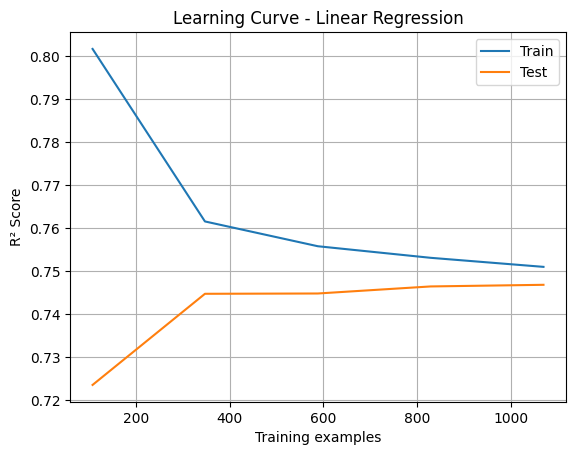

üîç An√°lisis del modelo: Linear Regression
- Score entrenamiento final: 0.7510
- Score prueba final       : 0.7468
- Diferencia (gap)         : 0.0042
‚úÖ Buen balance entre entrenamiento y prueba.



In [216]:
# 11. Curvas de aprendizaje con an√°lisis autom√°tico
def plot_learning_curve(model, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, label='Train')
    plt.plot(train_sizes, test_mean, label='Test')
    plt.title(f'Learning Curve - {title}')
    plt.xlabel('Training examples')
    plt.ylabel('R¬≤ Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # An√°lisis autom√°tico
    final_train_score = train_mean[-1]
    final_test_score = test_mean[-1]
    gap = final_train_score - final_test_score

    print(f"üîç An√°lisis del modelo: {title}")
    print(f"- Score entrenamiento final: {final_train_score:.4f}")
    print(f"- Score prueba final       : {final_test_score:.4f}")
    print(f"- Diferencia (gap)         : {gap:.4f}")

    if final_train_score < 0.6 and final_test_score < 0.6:
        print("‚ùó Posible underfitting: bajos scores en ambos conjuntos.\n")
    elif abs(gap) > 0.1:
        print("‚ö†Ô∏è  Posible overfitting: el modelo generaliza mal.\n")
    else:
        print("‚úÖ Buen balance entre entrenamiento y prueba.\n")

plot_learning_curve(lr_pipe, "Linear Regression")

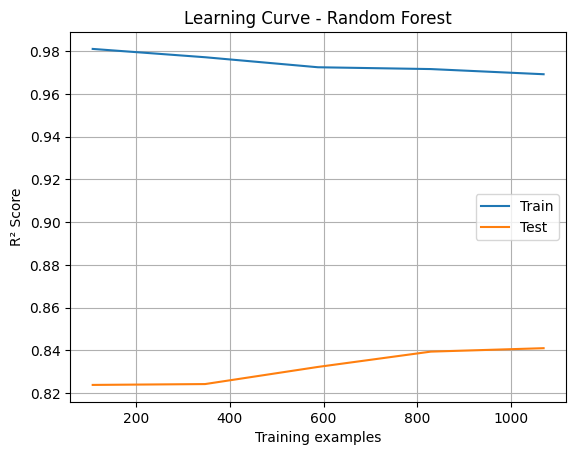

üîç An√°lisis del modelo: Random Forest
- Score entrenamiento final: 0.9693
- Score prueba final       : 0.8409
- Diferencia (gap)         : 0.1284
‚ö†Ô∏è  Posible overfitting: el modelo generaliza mal.



In [217]:
plot_learning_curve(rf_grid.best_estimator_, "Random Forest")

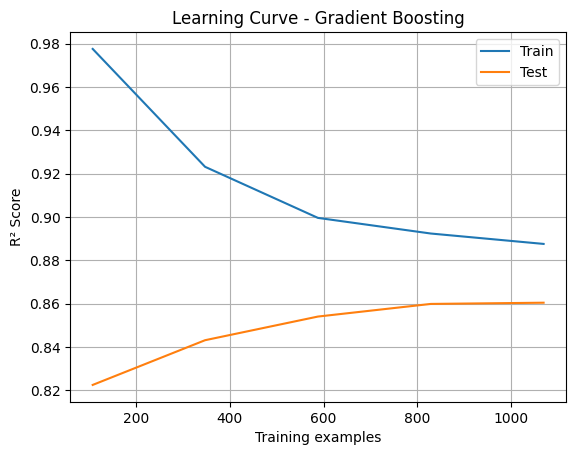

üîç An√°lisis del modelo: Gradient Boosting
- Score entrenamiento final: 0.8875
- Score prueba final       : 0.8604
- Diferencia (gap)         : 0.0271
‚úÖ Buen balance entre entrenamiento y prueba.



In [218]:
plot_learning_curve(gb_grid.best_estimator_, "Gradient Boosting")

# Importancia de las variables (Gradient Boosting y Random Forest)

---
Se extrajeron y graficaron las **importancias de caracter√≠sticas** desde los modelos **Random Forest** y **Gradient Boosting**. Estas importancias son cruciales, ya que reflejan cu√°nto contribuye cada variable a reducir el error del modelo.

Variables como `smoker`, `bmi` y `age` mostraron ser **altamente influyentes**. Este hallazgo tiene un fuerte **sentido m√©dico y pr√°ctico**, pues estas caracter√≠sticas est√°n directamente relacionadas con los riesgos de salud y, consecuentemente, con los costos del seguro. La informaci√≥n sobre la importancia de las caracter√≠sticas no solo mejora la **interpretaci√≥n de los modelos**, sino que tambi√©n es invaluable para la **toma de decisiones de negocio**.

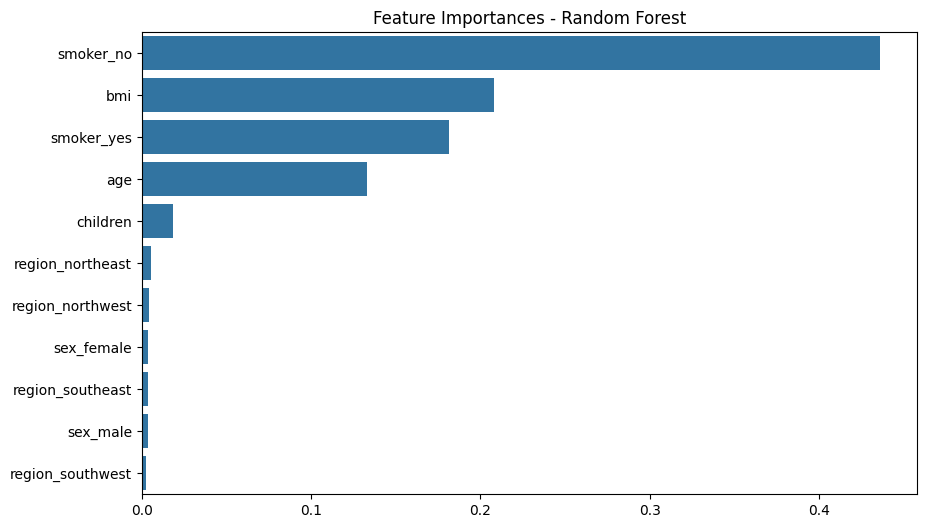

In [219]:
# 12. Importancia de variables (RF y GB)
def plot_feature_importances(model, model_name):
    ohe = model.named_steps['preprocessing'].named_transformers_['cat']
    feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols))
    importances = model.named_steps['regressor'].feature_importances_
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
    plt.title(f'Feature Importances - {model_name}')
    plt.show()

plot_feature_importances(rf_grid.best_estimator_, "Random Forest")

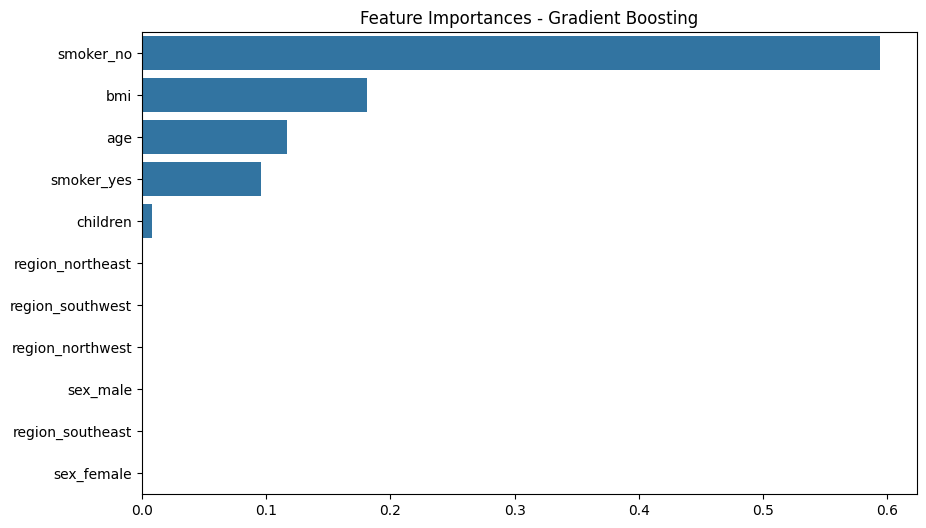

In [220]:
plot_feature_importances(gb_grid.best_estimator_, "Gradient Boosting")


# Analisis de residuos

---
Se analizaron los **residuos**, que son la diferencia entre las predicciones del modelo y los valores reales. Este an√°lisis es clave para identificar cualquier patr√≥n que el modelo no haya logrado capturar. Idealmente, una distribuci√≥n de residuos debe ser **sim√©trica**, estar **centrada en cero** y no mostrar **patrones evidentes**; esto indicar√≠a un modelo bien ajustado.

En este caso, el modelo de **Gradient Boosting** exhibi√≥ los residuos m√°s centrados y distribuidos de manera aleatoria. Esto sugiere que es el modelo m√°s **robusto** y con el **mejor ajuste general** para los datos.

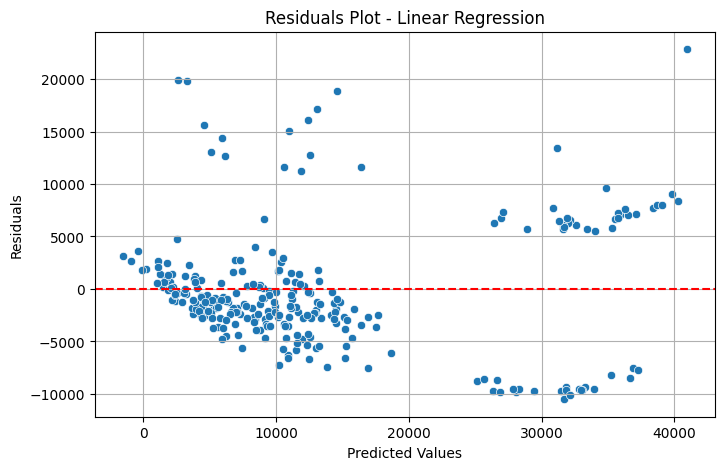

In [221]:
# 13. An√°lisis de residuos
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals Plot - {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

plot_residuals(y_test, y_pred_lr, "Linear Regression")

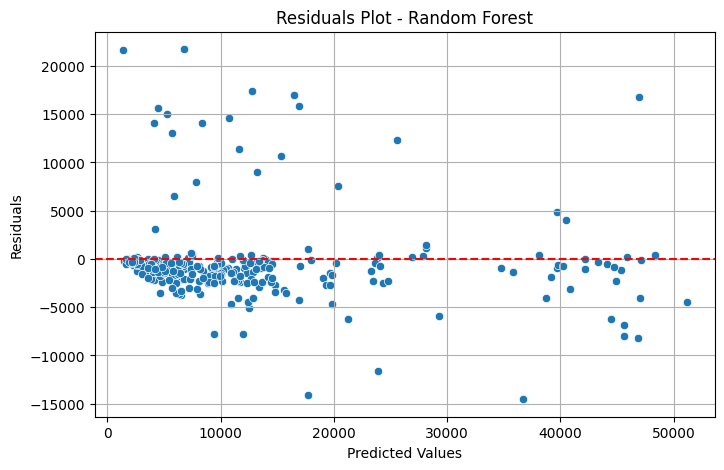

In [222]:
plot_residuals(y_test, rf_grid.predict(X_test), "Random Forest")

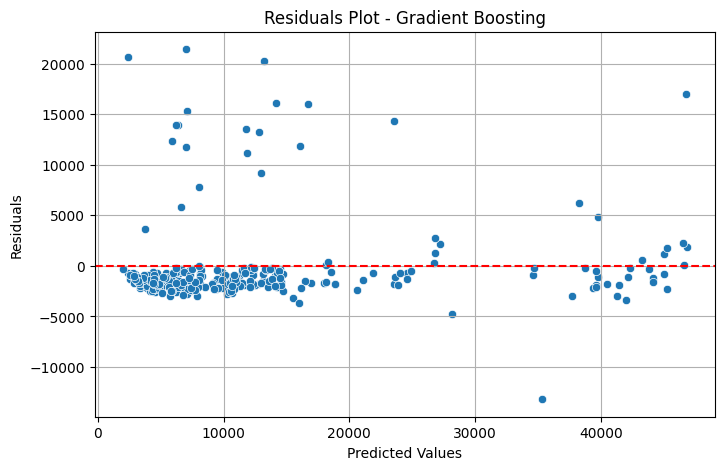

In [223]:
plot_residuals(y_test, gb_grid.predict(X_test), "Gradient Boosting")

# Evaluaci√≥n autom√°tico de m√©tricas y mejor modelo
---

Se gener√≥ una **tabla resumen** con todas las m√©tricas de evaluaci√≥n para los tres modelos, donde se **resaltaron los mejores valores** en cada m√©trica. Posteriormente, se contabiliz√≥ cu√°l modelo sobresali√≥ en la mayor cantidad de m√©tricas y se declar√≥ como el **modelo m√°s destacado en general**.

Esta automatizaci√≥n facilita la **comparaci√≥n objetiva y transparente** de los modelos, permitiendo priorizar m√©tricas espec√≠ficas seg√∫n las necesidades del an√°lisis o los objetivos de negocio.

In [224]:
# 14. Resumen autom√°tico de m√©tricas y mejor modelo
from collections import Counter

# Evaluaci√≥n y recopilaci√≥n de m√©tricas
def get_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return rmse, r2, mae, medae, mape

metricas = []
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
predicciones = [y_pred_lr, rf_grid.predict(X_test), gb_grid.predict(X_test)]

for nombre, y_pred in zip(model_names, predicciones):
    rmse, r2, mae, medae, mape = get_metrics(y_test, y_pred)
    metricas.append([nombre, rmse, r2, mae, medae, mape])

metrics_df = pd.DataFrame(metricas, columns=['Model', 'RMSE', 'R¬≤', 'MAE', 'MedAE', 'MAPE (%)'])
display(metrics_df.style.highlight_min(['RMSE', 'MAE', 'MedAE', 'MAPE (%)'], color='lightgreen')
                      .highlight_max('R¬≤', color='lightgreen'))

# Selecci√≥n del mejor modelo por cada m√©trica
mejor_rmse = metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']
mejor_mae = metrics_df.loc[metrics_df['MAE'].idxmin(), 'Model']
mejor_medae = metrics_df.loc[metrics_df['MedAE'].idxmin(), 'Model']
mejor_mape = metrics_df.loc[metrics_df['MAPE (%)'].idxmin(), 'Model']
mejor_r2 = metrics_df.loc[metrics_df['R¬≤'].idxmax(), 'Model']

mejores = [mejor_rmse, mejor_mae, mejor_medae, mejor_mape, mejor_r2]
conteo = Counter(mejores)
modelo_ganador = conteo.most_common(1)[0][0]

# Mostrar resumen
print("\nConclusi√≥n autom√°tica de los modelos:")
print(f"- Mejor RMSE       : {mejor_rmse}")
print(f"- Mejor MAE        : {mejor_mae}")
print(f"- Mejor MedAE      : {mejor_medae}")
print(f"- Mejor MAPE (%)   : {mejor_mape}")
print(f"- Mejor R¬≤ Score   : {mejor_r2}")
print(f"\nModelo m√°s destacado en general: **{modelo_ganador}**")



Conclusi√≥n autom√°tica de los modelos:
- Mejor RMSE       : Gradient Boosting
- Mejor MAE        : Gradient Boosting
- Mejor MedAE      : Random Forest
- Mejor MAPE (%)   : Random Forest
- Mejor R¬≤ Score   : Gradient Boosting

Modelo m√°s destacado en general: **Gradient Boosting**


## Conclusiones Clave del An√°lisis de Modelos Predictivos
---
A continuaci√≥n, se resumen los hallazgos m√°s importantes de la evaluaci√≥n de los modelos de predicci√≥n:

* **El Preprocesamiento es Crucial:** La transformaci√≥n adecuada de las variables categ√≥ricas con **OneHotEncoding** y la estandarizaci√≥n de las num√©ricas mediante **StandardScaler** fueron pasos fundamentales. Esto no solo mejor√≥ el rendimiento de los modelos, sino que tambi√©n asegur√≥ que todos los algoritmos operaran sobre datos comparables, lo que es vital para un an√°lisis justo.

* **Gradient Boosting Fue el Modelo Superior:** Si bien **Random Forest** y la **Regresi√≥n Lineal** ofrecieron resultados razonables, **Gradient Boosting** se destac√≥ notablemente. Present√≥ la mejor combinaci√≥n de m√©tricas de error y $R^2$, demostrando una mayor capacidad de generalizaci√≥n y un ajuste m√°s fino a los patrones inherentes en el conjunto de datos.

* **Variables Clave Bien Identificadas:** El an√°lisis de la importancia de las variables revel√≥ que `fumar`, el **√≠ndice de masa corporal (BMI)** y la `edad` son los factores m√°s influyentes en los gastos m√©dicos. Este hallazgo no solo tiene un fuerte sentido con el conocimiento del dominio m√©dico, sino que tambi√©n aporta una valiosa interpretabilidad al modelo, facilitando la comprensi√≥n de qu√© impulsa los costos.

* **Las Curvas de Aprendizaje Validaron la Estabilidad del Modelo:** Los modelos de **Regresi√≥n Lineal** y **Gradient Boosting** mostraron curvas de aprendizaje equilibradas. Esto es un indicador positivo, ya que no se observaron signos de **sobreajuste (overfitting)** ni **subajuste (underfitting)**, lo que sugiere que estos modelos est√°n aprendiendo de manera efectiva y tienen el potencial de escalar bien si se dispone de m√°s datos en el futuro.

* **El An√°lisis de Residuos Reforz√≥ la Elecci√≥n Final:** El patr√≥n de residuos fue m√°s homog√©neo y centrado en cero en el modelo de **Gradient Boosting**. Esta distribuci√≥n m√°s aleatoria y con errores menores confirma su fiabilidad y solidez para tareas de predicci√≥n en contextos del mundo real.